# Testing notebook for augmented episode

In [1]:
import gc
import os
import sys
import cv2
import json
import math
import pickle
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pytorch_lightning as pl

In [2]:
current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

# del sys.modules["notebooks.data_loaders.data_module"]
from notebooks.data_loaders.utils import Utilities
from notebooks.data_loaders.splitter import DataSplitter
from notebooks.models.model_provider import ModelProvider
from notebooks.data_loaders.data_module import DataModule
from notebooks.data_loaders.data_loader import CustomDataLoader
from notebooks.models.model_provider import ModelProvider
from notebooks.data_loaders.sequence_generator import SequenceGenerator

## Constants

In [32]:
FRAMES_IN = 10
FRAMES_OUT = 60
RESULT_FOLDER = "../../results/dots"

In [33]:
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

## Augmented sequence loading

In [45]:
# load dotted episode
filename = "../../3dmodel/dotted_episode/"
data = []
labels = json.load(open(filename+"labels_0.json"))
df = pd.DataFrame(labels)
df = df.transpose()

df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
df = df.astype({"pitch": float, "roll": float})
df['pitch'] = df['pitch'].apply(lambda x : Utilities.norm_pr(x))
df['roll'] = df['roll'].apply(lambda x : Utilities.norm_pr(x))

pr_input = df.iloc[0:FRAMES_IN]
pr_input = torch.Tensor(pr_input.to_numpy())
pr_input = pr_input.unsqueeze(0)

target_output = df.iloc[FRAMES_IN:FRAMES_IN+FRAMES_OUT].transpose()
target_output = torch.Tensor(target_output.to_numpy())
target_output = target_output.unsqueeze(0)
pr_input.shape, target_output.shape

(torch.Size([1, 10, 2]), torch.Size([1, 2, 60]))

In [46]:
# load dotted images
dotted_normal = []
dotted_gray = []
for index in range(FRAMES_IN):
    normal = cv2.imread(filename + str(index) + ".png")
    gray = cv2.imread(filename + str(index) + ".png", cv2.IMREAD_GRAYSCALE)
    normal = Utilities.norm_pixel(normal)
    gray = Utilities.norm_pixel(gray)
    dotted_normal.append(torch.Tensor(normal))
    dotted_gray.append(torch.Tensor(gray))

img_normal = torch.stack(dotted_normal)
# reshape (batch, frames in, channels, width, height)
img_normal = img_normal.permute(0,3,1,2)
img_normal = img_normal.unsqueeze(0)

img_gray = torch.stack(dotted_gray)
# unsqueeze batch and channel dimension
img_gray = img_gray.unsqueeze(1).unsqueeze(0)

img_normal.shape, img_gray.shape

(torch.Size([1, 10, 3, 54, 96]), torch.Size([1, 10, 1, 54, 96]))

## Model loading

In [14]:
MODEL_NAME = "CNN_gray_img-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs50'
gray_img_model = ModelProvider.cnn_lstm_single(FRAMES_IN, FRAMES_OUT, channels=1)
gray_img_model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [15]:
MODEL_NAME = "CNN_img-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs50'
img_model = ModelProvider.cnn_lstm_single(FRAMES_IN, FRAMES_OUT, channels=3)
img_model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [16]:
MODEL_NAME = "CNN_gray_img-PR-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs50'
gray_imgPR_model = ModelProvider.cnn_lstm_dual(FRAMES_IN, FRAMES_OUT, channels=1)
gray_imgPR_model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [17]:
MODEL_NAME = "CNN_img-PR-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs50'
imgPR_model = ModelProvider.cnn_lstm_dual(FRAMES_IN, FRAMES_OUT, channels=3)
imgPR_model.load_state_dict(torch.load(filename))

<All keys matched successfully>

### Testing

In [47]:
# make prediction with each model
with torch.no_grad():
    pred_gray_img = gray_img_model(img_gray)
    pred_img = img_model(img_normal)
    pred_gray_imgPR = gray_imgPR_model((img_gray, pr_input))
    pred_imgPR = imgPR_model((img_normal, pr_input))

# squeeze out batch size of 1
pred_gray_img = pred_gray_img.squeeze(0).apply_(Utilities.denorm_pr)
pred_img = pred_img.squeeze(0).apply_(Utilities.denorm_pr)
pred_gray_imgPR = pred_gray_imgPR.squeeze(0).apply_(Utilities.denorm_pr)
pred_imgPR = pred_imgPR.squeeze(0).apply_(Utilities.denorm_pr)

In [48]:
# clean up results for plotting
input_sequence = torch.transpose(pr_input.squeeze(0), 0, 1)
input_sequence.apply_(Utilities.denorm_pr)

target_output = df.iloc[FRAMES_IN:FRAMES_IN+FRAMES_OUT].transpose()
target_output = torch.Tensor(target_output.to_numpy())
target_output.apply_(Utilities.denorm_pr)

print(input_sequence.shape, target_output.shape)
pred_gray_img.shape, pred_img.shape, pred_gray_imgPR.shape, pred_imgPR.shape

torch.Size([2, 10]) torch.Size([2, 60])


(torch.Size([2, 60]),
 torch.Size([2, 60]),
 torch.Size([2, 60]),
 torch.Size([2, 60]))

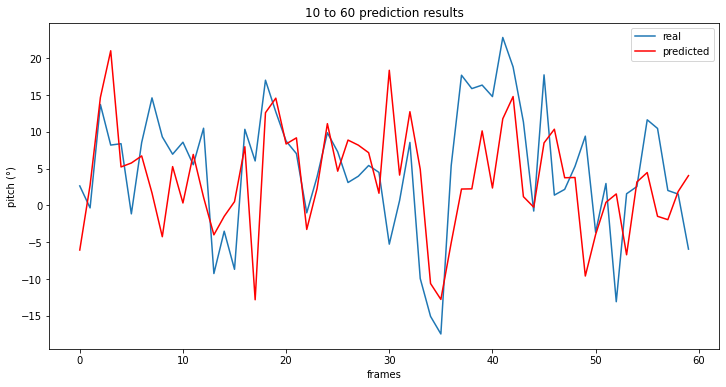

In [69]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(target_output[0], label="real")
# ax.plot(frames[FRAMES_IN:], pred_gray_img[0], label='img_gray', color='orange', linestyle="-.")
ax.plot(pred_img[0], color='red', label="predicted")
# ax.plot(frames[FRAMES_IN:], pred_gray_imgPR[0], label='img-PR_gray', color='gray', linestyle="--")
#ax.plot(frames[FRAMES_IN:], pred_imgPR[0], label='img-PR')

ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/dots_pitch_{FRAMES_IN}in_{FRAMES_OUT}out', bbox_inches='tight')
plt.show()

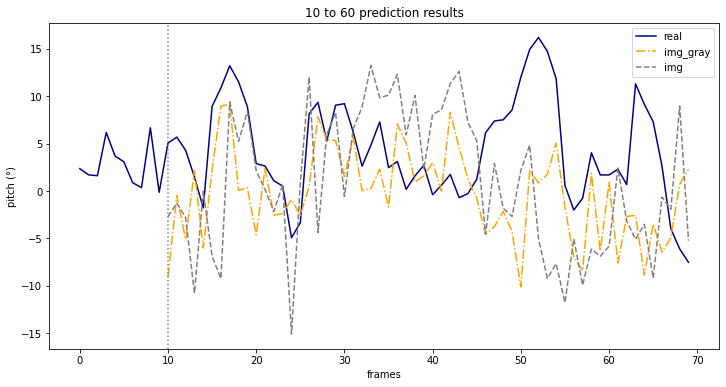

In [64]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(frames, torch.cat((input_sequence[1], target_output[1])), label="real", color='navy')
ax.plot(frames[FRAMES_IN:], pred_gray_img[1], label='img_gray', color='orange', linestyle="-.")
ax.plot(frames[FRAMES_IN:], pred_img[1], label='img', color='gray', linestyle="--")
#ax.plot(frames[FRAMES_IN:], pred_gray_imgPR[1], label='img-PR_gray')
#ax.plot(frames[FRAMES_IN:], pred_imgPR[1], label='img-PR')

plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/dots_roll_{FRAMES_IN}in_{FRAMES_OUT}out', bbox_inches='tight')
plt.show()